<a href="https://colab.research.google.com/github/tramyynt/Delivery-Hiring/blob/main/Delivery_Hiring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
import pandas as pd
import numpy as np
from datetime import date, datetime
import numpy as np
import calendar

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px

import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,cross_val_score

from sklearn.metrics import r2_score
import sklearn.metrics as metrics

Data Cleaning and Preprocessing

In [7]:
order = pd.read_csv('/content/drive/MyDrive/Deliveroo Hiring - Test for Machine Learning Engineering/orders.csv.gz (Unzipped Files)/orders.csv')
restaurant = pd.read_csv('/content/drive/MyDrive/Deliveroo Hiring - Test for Machine Learning Engineering/restaurants.csv.gz (Unzipped Files)/restaurants.csv')

In [4]:
order.head(5)

,order_acknowledged_at,order_ready_at,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds
0,2015-06-01 12:28:28.952789+01:00,2015-06-01 14:12:09.474896+01:00,59.90,1326,2,6220
1,2015-06-06 17:06:24.434807+01:00,2015-06-06 17:16:27.520253+01:00,24.00,1326,8,603
2,2015-06-08 14:56:15.503204+01:00,2015-06-08 15:03:39.397496+01:00,15.25,1326,3,443
3,2015-06-12 15:12:20.497925+01:00,2015-06-12 15:23:30.064683+01:00,28.05,1326,8,669
4,2015-06-01 13:07:10.794050+01:00,2015-06-01 14:02:25.104517+01:00,56.30,255,7,3314


In [5]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32394 entries, 0 to 32393
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   order_acknowledged_at  32394 non-null  object 
 1   order_ready_at         32394 non-null  object 
 2   order_value_gbp        32394 non-null  float64
 3   restaurant_id          32394 non-null  int64  
 4   number_of_items        32394 non-null  int64  
 5   prep_time_seconds      32394 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.5+ MB


In [6]:
order.isnull().sum()

order_acknowledged_at    0
order_ready_at           0
order_value_gbp          0
restaurant_id            0
number_of_items          0
prep_time_seconds        0
dtype: int64

In [7]:
restaurant.isnull().sum()

restaurant_id    0
country          0
city             0
type_of_food     0
dtype: int64

In [8]:
restaurant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697 entries, 0 to 1696
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   restaurant_id  1697 non-null   int64 
 1   country        1697 non-null   object
 2   city           1697 non-null   object
 3   type_of_food   1697 non-null   object
dtypes: int64(1), object(3)
memory usage: 53.2+ KB


In [62]:
#check if restaurant is primary key
print(restaurant['restaurant_id'].nunique())
print(order['restaurant_id'].nunique())

1697
1697


In [8]:
#merge two dataframes into df dataset
order = pd.merge(order, restaurant, on='restaurant_id')

In [9]:
#convert object to datetime type
order['order_acknowledged_at']=pd.to_datetime(order['order_acknowledged_at'], utc=True,format='%Y-%m-%d %H:%M:%S')
order['order_ready_at'] = pd.to_datetime(order['order_ready_at'], utc= True,format='%Y-%m-%d %H:%M:%S')

In [10]:
#sort order by acknowledged time
order = order.sort_values(by = 'order_acknowledged_at')
order.reset_index(inplace= True)
order.drop(columns = 'index')

,order_acknowledged_at,order_ready_at,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds,country,city,type_of_food
0,2015-06-01 09:34:00.351812+00:00,2015-06-01 13:02:30.351682+00:00,15.10,2276,3,12509,UK,London,healthy
1,2015-06-01 10:22:56.328104+00:00,2015-06-01 12:23:57.316309+00:00,36.00,2276,4,7260,UK,London,healthy
2,2015-06-01 10:39:44.491932+00:00,2015-06-01 12:31:32.205864+00:00,48.00,604,1,6707,UK,London,american
3,2015-06-01 10:50:44.072478+00:00,2015-06-01 12:24:36.777383+00:00,35.45,1518,4,5632,UK,London,healthy
4,2015-06-01 11:02:23.080222+00:00,2015-06-01 12:48:49.660816+00:00,17.35,666,4,6386,UK,London,dessert
...,...,...,...,...,...,...,...,...,...
32389,2015-06-30 22:56:41.726710+00:00,2015-06-30 23:04:35.997701+00:00,13.85,775,3,474,UK,London,burgers
32390,2015-06-30 22:57:12.656303+00:00,2015-06-30 23:02:31.650475+00:00,20.50,2855,2,318,UK,London,american
32391,2015-06-30 22:59:46.852778+00:00,2015-06-30 23:02:26.589807+00:00,47.80,1475,3,159,UK,London,chinese
32392,2015-06-30 23:03:12.344312+00:00,2015-06-30 23:11:15.464365+00:00,20.95,2728,5,483,UK,Edinburgh,chicken


In [11]:
#split date time
order['ord_ack_date']= order['order_acknowledged_at'].dt.date
order['ord_ready_date'] = order['order_ready_at'].dt.date

#get the hour of the order from date time.
order['ord_hour']= order['order_acknowledged_at'].dt.hour

order['day_number'] = order['order_acknowledged_at'].dt.dayofweek
order['order_day'] = order['order_acknowledged_at'].dt.day_name()

#order['week_day'] = order['order_acknowledged_at'].apply(lambda x: calendar.day_name[x.weekday()])

### Exploratory Data Analysis

Order by hour

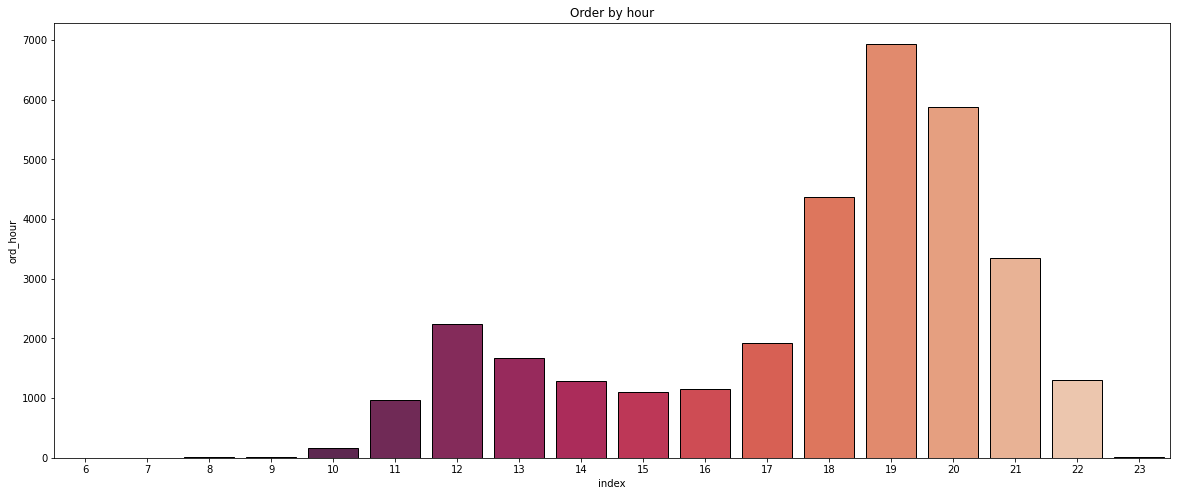

In [12]:
temp = order['ord_hour'].value_counts().to_frame().reset_index()

plt.figure(figsize=(20,8))
sns.barplot(data = temp, x = 'index', y = 'ord_hour', palette ='rocket', edgecolor ='black')
plt.title('Order by hour')
plt.show()

As we can see, most orders are placed between 6pm:9pm

In [ ]:
# order['ord_ack_date']=pd.to_datetime(order['ord_ack_date'])
# # order['ord_ack_time']=pd.to_datetime(order['ord_ack_time'])
# order['ord_ready_date']=pd.to_datetime(order['ord_ready_date'])
# # order['ord_ready_time']=pd.to_datetime(order['ord_ready_time'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


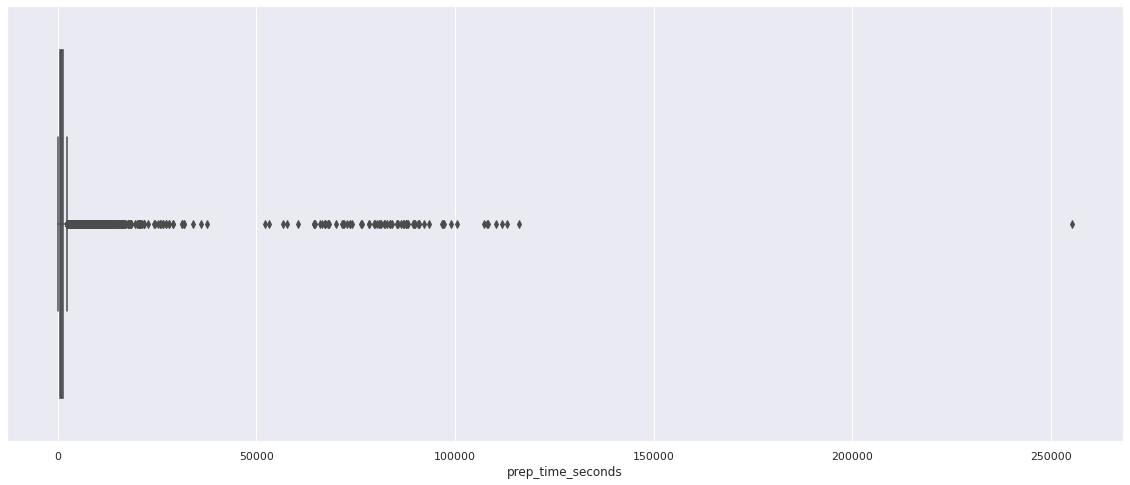

In [13]:
#check the distribution of target feature
sns.set(rc={'figure.figsize':(20,8)})
sns.boxplot(order['prep_time_seconds'])
plt.show()

Considering that the pre_orders do not affect preparation time of restaurants, and also those orders just take up 0.02%.
So we only consider the orders processed within a day.

In [14]:
#check if there are pre_orders for next day
diff= pd.to_datetime(order['ord_ready_date'],utc = True) - pd.to_datetime(order['ord_ack_date'], utc = True)
order['diff'] = pd.DataFrame(diff)
order['diff'] = pd.DataFrame(diff)
order['diff'] = order['diff'].astype(int)

ord = order[order['diff'] ==0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  """


In [54]:
ord=ord.drop(columns ='diff')

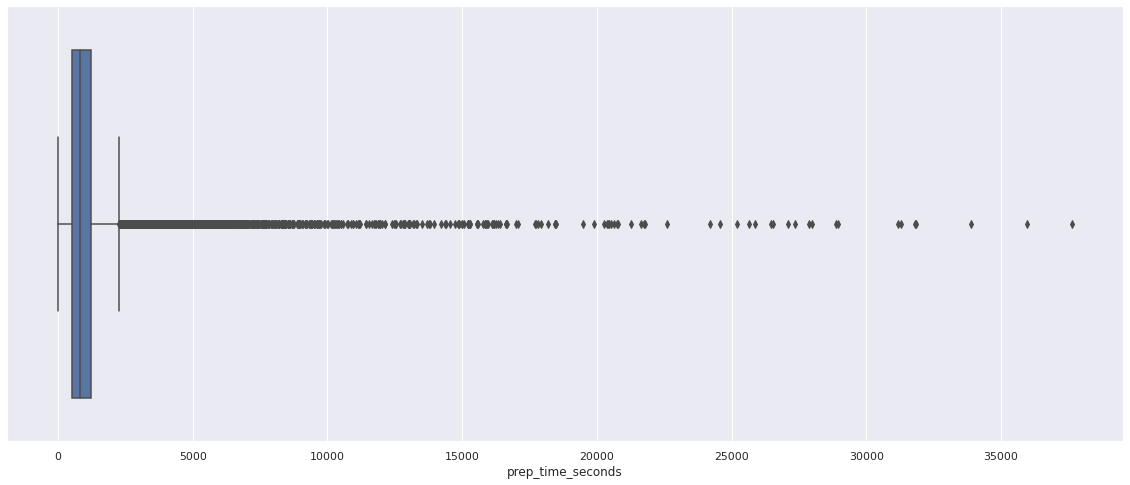

In [15]:
plt.figure(figsize =(20,8))
sns.boxplot(data = ord, x = ord['prep_time_seconds'])
plt.show()

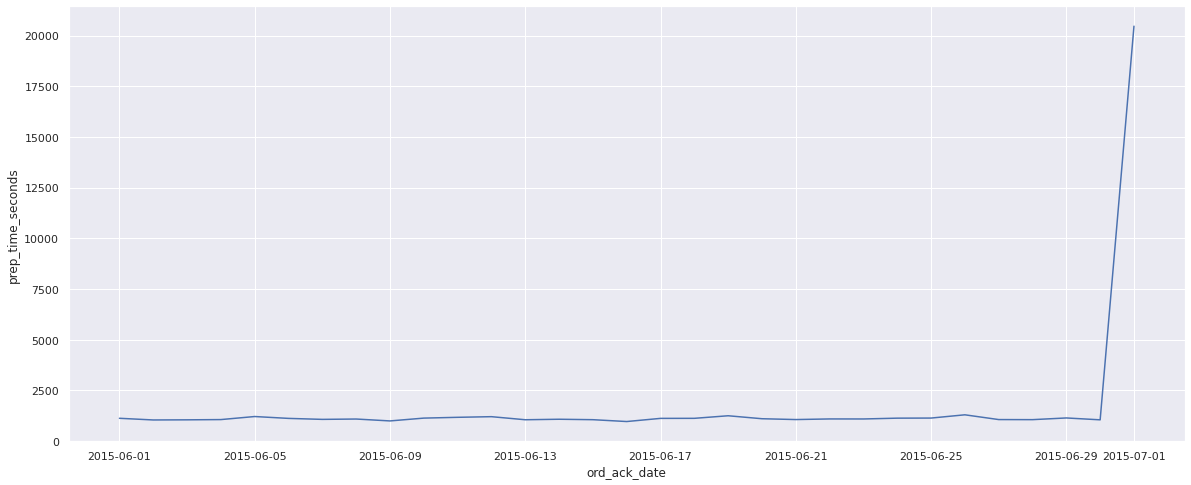

In [16]:
#overall preparation time
pre_overall = ord[['prep_time_seconds','ord_ack_date']].groupby('ord_ack_date').mean().reset_index()
plt.figure(figsize = (20,8))
sns.lineplot(data = pre_overall, y ="prep_time_seconds", x ='ord_ack_date', palette ='rocket')
plt.show()

In [17]:

pre_day = ord[['prep_time_seconds','order_day','order_value_gbp']].groupby('order_day').agg({'prep_time_seconds': 'mean','order_value_gbp':'mean'}).reset_index()
cate = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
pre_day["order_day"] = pd.Categorical(pre_day["order_day"], categories = cate)
pre_day.sort_values(by = "order_day")

,order_day,prep_time_seconds,order_value_gbp
3,Sunday,1068.835669,25.427468
1,Monday,1103.010811,26.312181
5,Tuesday,1033.021609,26.047164
6,Wednesday,1116.809949,26.222773
4,Thursday,1124.382749,26.239237
0,Friday,1242.526703,28.042549
2,Saturday,1086.739448,26.110057


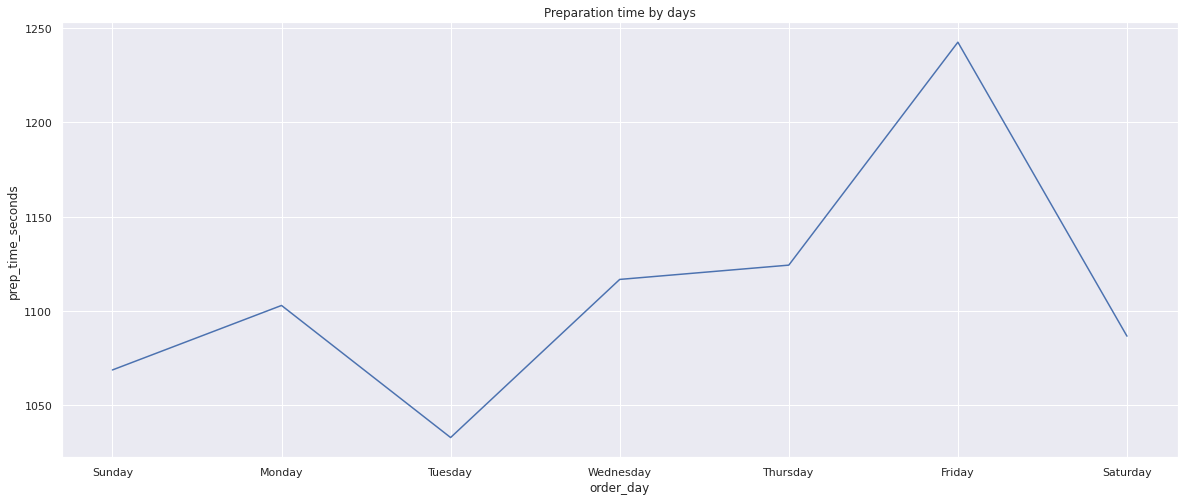

In [18]:
#trend by day

plt.figure(figsize = (20,8))

sns.lineplot(data=pre_day, x = pre_day['order_day'], y= pre_day['prep_time_seconds'], palette='rocket' )
plt.title('Preparation time by days')
plt.show()

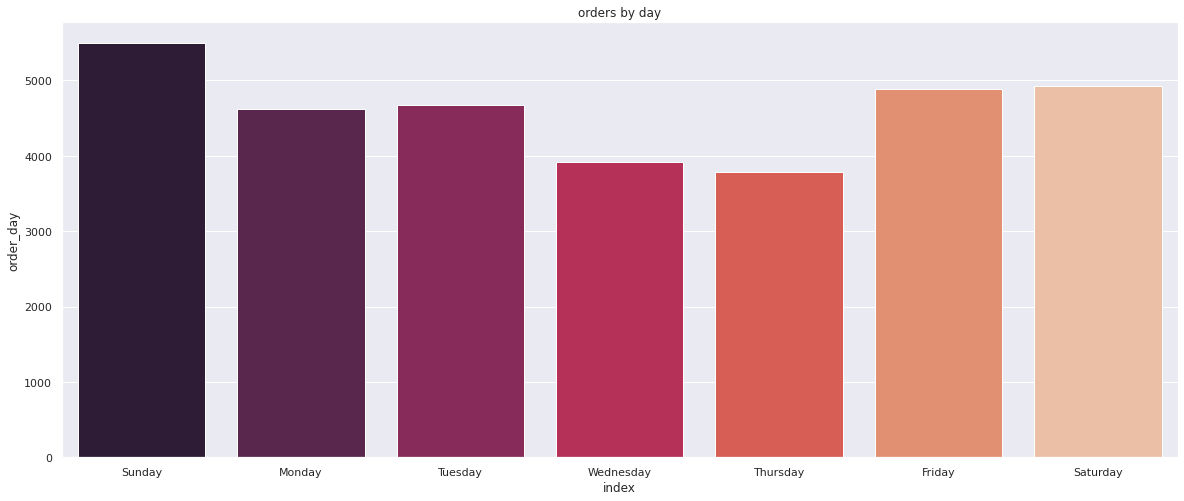

In [19]:
plt.figure(figsize=(20,8))
sns.barplot(data=ord['order_day'].value_counts().reindex(cate).to_frame().reset_index(),x='index', y= 'order_day', palette='rocket')
plt.title('orders by day')
plt.show()

As observed, the most orders were made on weekend. However, the preparation time is much higher on Friday and is the second lowest on Sunday.

Orders by cities

In [20]:
countries = ord['country'].value_counts().reset_index().rename(columns ={'country':'count'})
countries['percent'] = countries['count']/countries['count'].sum()*100

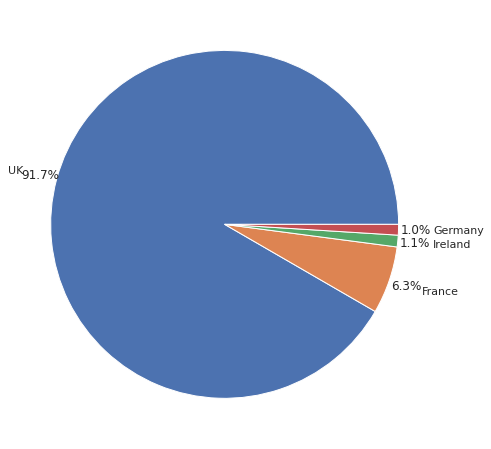

In [175]:
plt.figure(figsize=(20,8))
sns.set(font_scale = 1.0)
plt.pie(data = countries, x ='percent',autopct='%1.1f%%',pctdistance=1.1, labeldistance=1.2, labels = 'index')
plt.show()

As shown in the figure above, UK has the most orders, which takes up over 90% the total orders.

Number of orders by cities

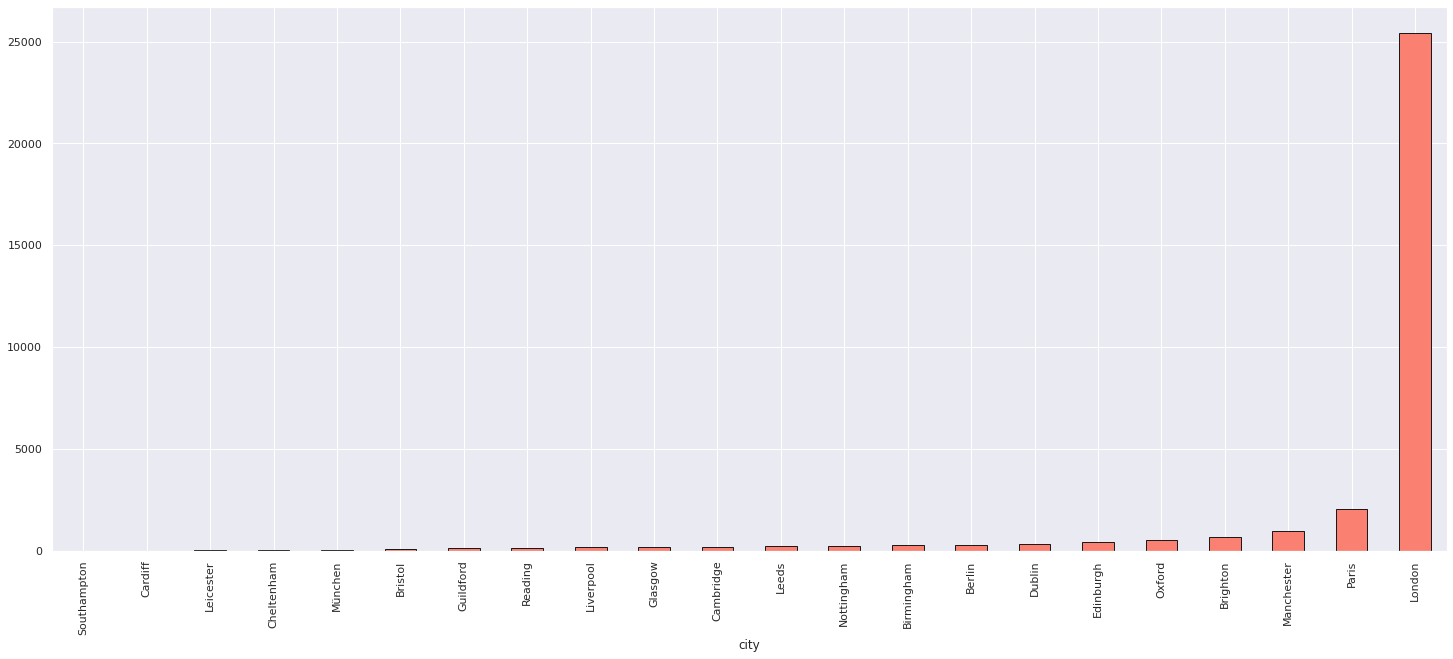

In [35]:
plt.figure(figsize=(25,10))
sns.set(font_scale = 1)
ord.groupby('city').count()['order_value_gbp'].sort_values().plot(kind='bar',color='salmon',edgecolor='k')
plt.show()

It can be seen that the most orders are from London

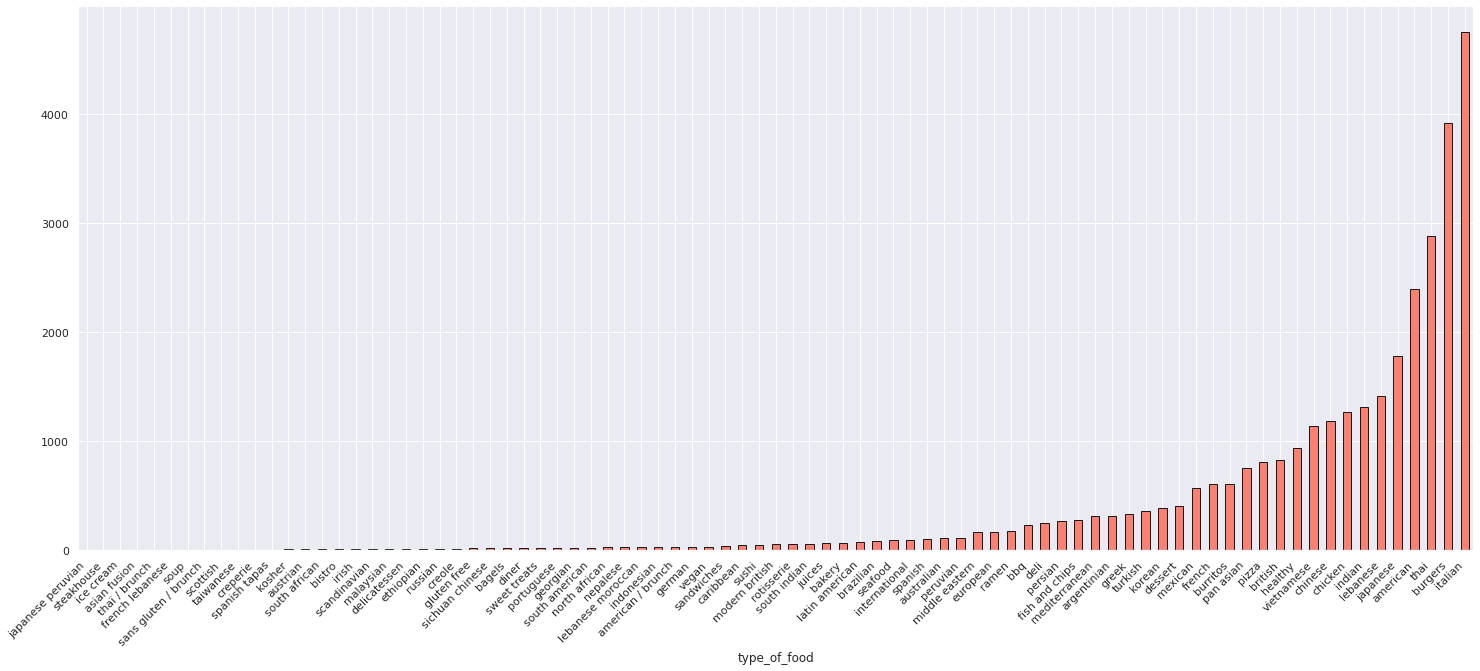

In [36]:
plt.figure(figsize=(25,10))
sns.set(font_scale = 1)
ord.groupby('type_of_food').count()['order_value_gbp'].sort_values().plot(kind='bar',color='salmon',edgecolor='k')
plt.xticks(rotation=45, ha='right')
plt.show()

As the figure reveals, Italian, Burges and Thai are the most ordered types of food.

In [ ]:
#price_per_item
ord['price_per_item'] =round(ord['order_value_gbp']/ord['number_of_items'],1)

In [ ]:
bins =[0,10,25,45,1000]
labels =['low','medium','high','too high']
ord['price_range'] = pd.cut(ord['price_per_item'], bins,labels=labels)

#can use numpy select to match condition with label

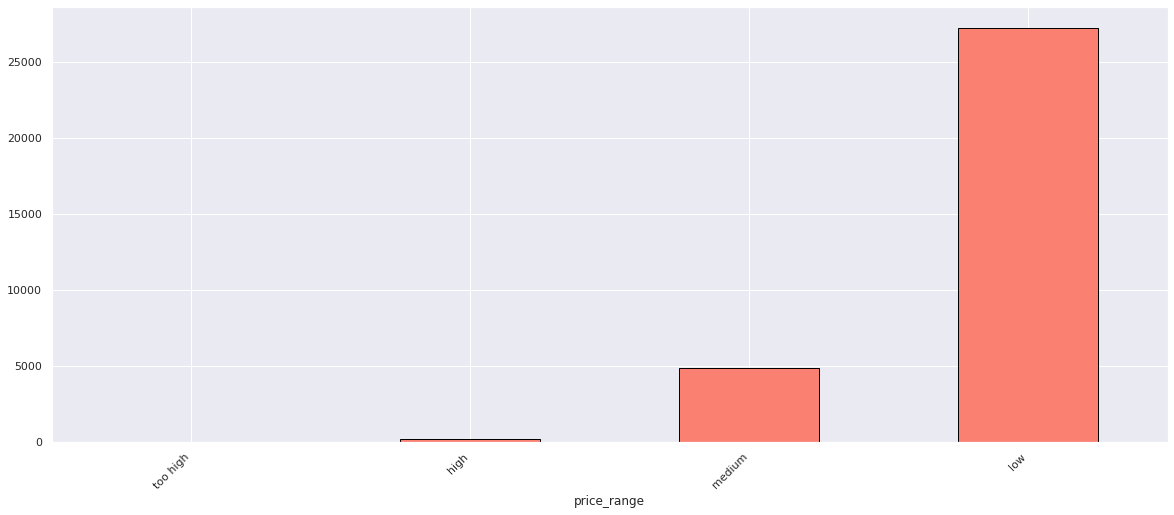

In [52]:
plt.figure(figsize=(20,8))
sns.set(font_scale = 1)
ord.groupby('price_range').count()['order_value_gbp'].sort_values().plot(kind = 'bar', color ='salmon', edgecolor = 'black')
plt.xticks(rotation=45, ha='right')
plt.show()

Correlation Matrix

Correlation Matrix is used to do feature engineering which is process to select the most relevant variables

In [ ]:
ord = ord.drop(columns = 'index')

In [ ]:
#order.corr('pearson')['prep_time_seconds'].loc['ack_day'] #pearson --> linearity, spearman --> monotonic relationship

0.005318490738610632

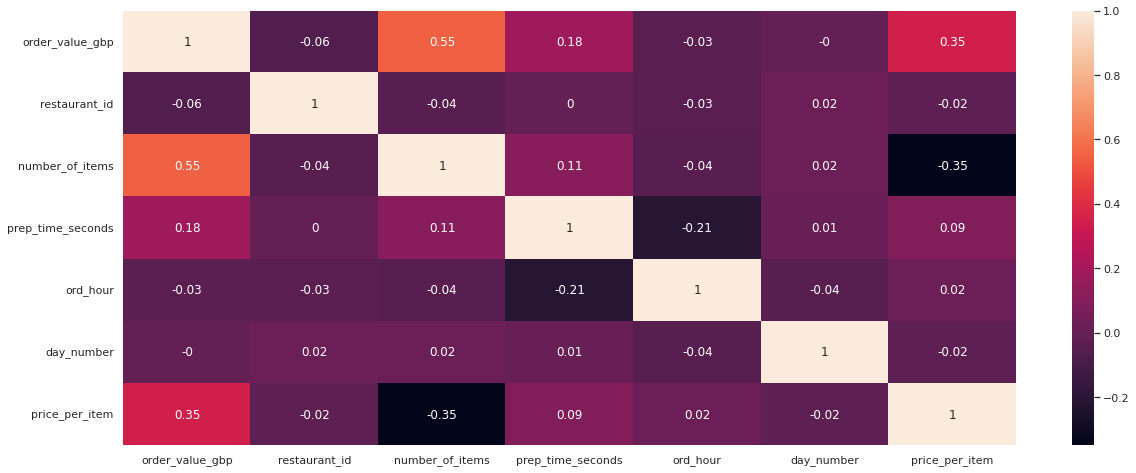

In [61]:
#pearson --> linearity, spearman --> monotonic relationship
plt.figure(figsize =(20,8))
cor_matrix = ord.corr('pearson').round(2)
sns.heatmap(data = cor_matrix,annot = True)
plt.show()

###One-hot encoding

In [70]:
df = pd.concat( [ord, pd.get_dummies(ord.price_range, prefix = 'Price_range') ] , axis = 1)
df = pd.concat( [df, pd.get_dummies(df.city, prefix = 'City') ] , axis = 1)
df = pd.concat( [df, pd.get_dummies(df.country, prefix = 'Country') ] , axis = 1)

In [90]:
df.columns

Index(['order_acknowledged_at', 'order_ready_at', 'order_value_gbp',
       'restaurant_id', 'number_of_items', 'prep_time_seconds', 'country',
       'city', 'type_of_food', 'ord_ack_date', 'ord_ready_date', 'ord_hour',
       'day_number', 'order_day', 'price_per_item', 'price_range',
       'Price_range_low', 'Price_range_medium', 'Price_range_high',
       'Price_range_too high', 'City_Berlin', 'City_Birmingham',
       'City_Brighton', 'City_Bristol', 'City_Cambridge', 'City_Cardiff',
       'City_Cheltenham', 'City_Dublin', 'City_Edinburgh', 'City_Glasgow',
       'City_Guildford', 'City_Leeds', 'City_Leicester', 'City_Liverpool',
       'City_London', 'City_Manchester', 'City_München', 'City_Nottingham',
       'City_Oxford', 'City_Paris', 'City_Reading', 'City_Southampton',
       'Country_France', 'Country_Germany', 'Country_Ireland', 'Country_UK'],
      dtype='object')

### Modelling

In [97]:
#train_test_split
X = df.loc[:,~df.columns.isin(["prep_time_seconds",'restaurant_id','order_acknowledged_at', 'order_ready_at','ord_ack_date', 'ord_ready_date','order_day','day_number','country','city','price_range','type_of_food'])]
y= df['prep_time_seconds']

X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.3,shuffle= True)

In [115]:
#select algorithms
# linear regression, ridge regression, decision tree, random forest regression
reg_dict = {'lm': LinearRegression(), 
            'ridge': Ridge(), 
            #'decision_tree': DecisionTreeRegressor(criterion ='mse', random_state=42),
            'random_forest': RandomForestRegressor(n_estimators=100, random_state=42)}
for name, reg in reg_dict.items():
    pred = reg.fit(X_train, y_train)
    y_pred = pred.predict(X_test)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('MAE (Mean-Absolute-Error): %s' %mae)
    print('MSE (Mean-Squared-Error) : %s' %mse)
    print('RMSE (Root-MSE): %s' %rmse)

MAE (Mean-Absolute-Error): 669.5344784906331
MSE (Mean-Squared-Error) : 2309024.1516449996
RMSE (Root-MSE): 1519.5473509058543
MAE (Mean-Absolute-Error): 669.4307811727944
MSE (Mean-Squared-Error) : 2308833.191647188
RMSE (Root-MSE): 1519.4845151060895
MAE (Mean-Absolute-Error): 691.4414826163237
MSE (Mean-Squared-Error) : 2406045.1795442738
RMSE (Root-MSE): 1551.1431847332062


In [114]:
#use decision tree with GridCV
rf = Ridge()
model = rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)

In [103]:
#Evaluate
mae = metrics.mean_absolute_error(y_test, y_predict)
mse = metrics.mean_squared_error(y_test, y_predict)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_predict))
r2 = metrics.r2_score(y_test, y_predict)

print('MAE (Mean-Absolute-Error): %s' %mae)
print('MSE (Mean-Squared-Error): %s' %mse)
print('RMSE (Root-MSE): %s' %rmse)
print('R2 score: %s' %r2)


MAE (Mean-Absolute-Error): 688.7622759385719
MSE (Mean-Squared-Error): 2385146.973786494
RMSE (Root-MSE): 1544.3921049353025
R2 score: 0.04127924537350247


In [ ]:
#Using cross-validation
kf= KFold(n_splits = 5, shuffle = True, random_state = 27)
for name, reg in reg_dict.items():
    pred = reg.fit(X_train, y_train)
    y_pred = pred.predict(X_test)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('MAE (Mean-Absolute-Error): %s' %mae)
    print('MSE (Mean-Squared-Error) : %s' %mse)
    print('RMSE (Root-MSE): %s' %rmse)

random_forest = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=20, min_samples_split=2)
cv_score = cross_val_score(random_forest, X_train, y_train, scoring='r2', cv=kf)
cv_score

array([-0.06073019, -0.045454  , -0.01012607, -0.07885548, -0.01567793])

In [ ]:
error2 = pd.DataFrame({'Actual-Values': np.array(y_test).flatten(), 'Predicted-Values': predi.flatten()})

In [ ]:
error2.head(10)

,Actual-Values,Predicted-Values
0,529,958.934374
1,2479,308.213872
2,1916,894.053962
3,1157,987.333148
4,910,994.722235
5,439,976.823867
6,4997,1115.905949
7,565,949.709052
8,1476,2287.398382
9,801,1059.030191


In [ ]:
#Train model with scaling
#SCALING FEATURE:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
#train_test_split
X = ord_selected_dummies.loc[:,~ord_selected_dummies.columns.isin(["prep_time_seconds"])]
y= ord_selected_dummies['prep_time_seconds']

df = pd.DataFrame(scaler.fit_transform(X))

X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.3,shuffle= True)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115
0,2.851852,0.097133,-0.5,7.650142,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.192593,0.097133,2.5,-0.305949,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.455556,0.097133,0.0,-0.532578,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.492593,0.097133,2.5,-0.212465,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.585185,-0.529549,2.0,3.533994,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
kf= KFold(n_splits = 5, shuffle = True, random_state = 27)
random_forest = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=20, min_samples_split=2)
cv_score = cross_val_score(random_forest, X_train, y_train, scoring='r2', cv=kf)
cv_score

array([-0.0209017 , -0.07528681, -0.07066732, -0.04157089, -0.03210499])

In [ ]:
random_forest.fit(X_train, y_train)
predi= random_forest.predict(X_test)
mae = metrics.mean_absolute_error(y_test, predi)
mse = metrics.mean_squared_error(y_test, predi)
rmse = np.sqrt(metrics.mean_squared_error(y_test, predi))
r2 = metrics.r2_score(y_test, predi)

print('MAE (Mean-Absolute-Error): %s' %mae)
print('MSE (Mean-Squared-Error): %s' %mse)
print('RMSE (Root-MSE): %s' %rmse)
print('R2 score: %s' %r2)

MAE (Mean-Absolute-Error): 671.2496571071515
MSE (Mean-Squared-Error): 2104863.390928735
RMSE (Root-MSE): 1450.8147334958846
R2 score: -0.04516916090460832
